In [232]:
# from pyspark.sql import SparkSession
import pandas as pd

# # Create Spark session (only needed in some environments like local mode)
# spark = SparkSession.builder.appName("a5").getOrCreate()

In [233]:
# Create bikeDF
filePath = "gs://class_demo_bucket-1/capitalbikeshare.csv"

bikeDF = spark.read.csv(filePath, header=True, inferSchema=True)
bikeDF = bikeDF.select("instant", "dteday", "season", "yr", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed", "casual", "registered", "count")
# bikeDF.show()

pandas_df = bikeDF.toPandas()
pandas_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [234]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int32  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int32  
 3   yr          17379 non-null  int32  
 4   mnth        17379 non-null  int32  
 5   hr          17379 non-null  int32  
 6   holiday     17379 non-null  int32  
 7   weekday     17379 non-null  int32  
 8   workingday  17379 non-null  int32  
 9   weathersit  17379 non-null  int32  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int32  
 15  registered  17379 non-null  int32  
 16  count       17379 non-null  int32  
dtypes: float64(4), int32(12), object(1)
memory usage: 1.5+ MB


In [235]:
bikeDF.select("weathersit", "temp", "hum", "windspeed", "casual", "registered", "count").summary().show()

+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|        weathersit|               temp|                hum|          windspeed|           casual|        registered|             count|
+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|             17379|              17379|              17379|              17379|            17379|             17379|             17379|
|   mean| 1.425283387997008| 0.4969871684216586| 0.6272288394038822| 0.1900976063064631|35.67621842453536|153.78686920996606|189.46308763450142|
| stddev|0.6393568777542525|0.19255612124972202|0.19292983406291458|0.12234022857279034|49.30503038705298|151.35728591258325| 181.3875990918646|
|    min|                 1|               0.02|                0.0|                0.0|                0|                 0|     

In [236]:
# Average ridership count by season
pandas_df.groupby('season')['count'].mean()

season
1    111.114569
2    208.344069
3    236.016237
4    198.868856
Name: count, dtype: float64

In [237]:
# Split the dataframe into trainDF and testDF
trainDF, testDF = bikeDF.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set,
and {testDF.count()} in the test set.""")

There are 13961 rows in the training set,
and 3418 in the test set.


In [238]:
# Assemble features into a vector
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler (
    # A list of feature column names that we want to include in our model
    # VectorAssembler will combine them into a single feature vector.
    inputCols=["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed"],
    outputCol="features"
)
vecTrainDF = vecAssembler.transform(trainDF)
vecTrainDF.select("features", "count").show(5)

+--------------------+-----+
|            features|count|
+--------------------+-----+
|[1.0,1.0,0.0,0.0,...|   16|
|[1.0,1.0,1.0,0.0,...|   40|
|[1.0,1.0,3.0,0.0,...|   13|
|[1.0,1.0,4.0,0.0,...|    1|
|[1.0,1.0,5.0,0.0,...|    1|
+--------------------+-----+
only showing top 5 rows



In [239]:
# Define and train the decision tree regressor
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(
    featuresCol="features", # Tells the model which column contains the feature vector.
    labelCol="count", # The name of the target variable (dependent variable) -- what the model is trying to predict
    maxDepth=10,  # Controls overfitting
    minInstancesPerNode=20,  # Forces more general splits
    maxBins=64,
    minInfoGain=0.01
)

In [240]:
# from pyspark.ml.regression import LinearRegression
# lr = LinearRegression(
#     featuresCol="features",
#     labelCol="count",
# )

In [241]:
# Pipeline
from pyspark.ml import Pipeline

# Create pipeline object
pipeline = Pipeline(stages=[vecAssembler, dt])

# Train the model / fit the pipeline on training data
pipelineModel = pipeline.fit(trainDF)

# Make predictions
# Apply the trained pipeline to test data
predDF = pipelineModel.transform(testDF) # piplineModel is a trained ML pipeline
predDF.select("season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed", "count", "prediction").show(24)

+------+----+---+-------+-------+----------+----------+----+------+----+---------+-----+------------------+
|season|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|count|        prediction|
+------+----+---+-------+-------+----------+----------+----+------+----+---------+-----+------------------+
|     1|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|   32|             21.15|
|     1|   1|  6|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|    2|               4.4|
|     1|   1|  8|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|    8| 55.46153846153846|
|     1|   1| 13|      0|      6|         0|         2|0.46|0.4545|0.72|   0.2985|   94|214.65734265734267|
|     1|   1| 19|      0|      6|         0|         3|0.42|0.4242|0.88|   0.2537|   37|46.206896551724135|
|     1|   1| 23|      0|      6|         0|         2|0.46|0.4545|0.88|   0.2985|   39| 61.95454545454545|
|     1|   1|  6|      0|   

In [242]:
# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
regressionEvaluator = RegressionEvaluator (
    predictionCol="prediction",
    labelCol="count",
    metricName="rmse"
)
rmse = regressionEvaluator.evaluate(predDF) 
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 78.24967206520715


In [243]:
# Access the trained decision tree model
treeModel = pipelineModel.stages[1] # dt is the 2nd stage

# Print feature importances
print(treeModel.featureImportances)

feature_names = vecAssembler.getInputCols()
importances = treeModel.featureImportances

for name, importance in zip(feature_names, importances.toArray()):
    print(f"{name}: {importance:.4f}")

(11,[0,1,2,3,4,5,6,7,8,9,10],[0.022330335868939073,0.003380755708763049,0.6944798724691597,0.0014350297590183083,0.005677693250717501,0.07250305377056122,0.015942223586016144,0.14212081701958124,0.01059517030635735,0.029370908830952742,0.0021641394299337664])
season: 0.0223
mnth: 0.0034
hr: 0.6945
holiday: 0.0014
weekday: 0.0057
workingday: 0.0725
weathersit: 0.0159
temp: 0.1421
atemp: 0.0106
hum: 0.0294
windspeed: 0.0022


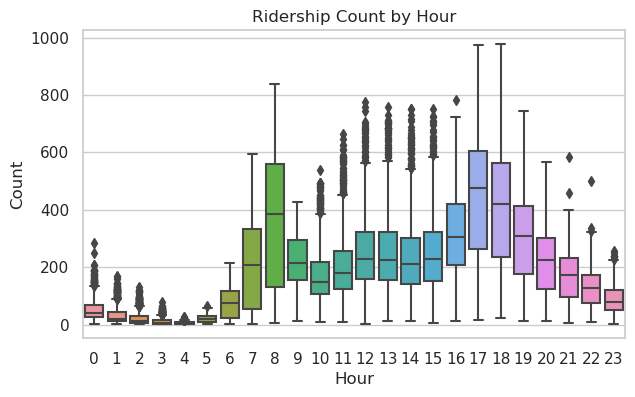

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (7, 4))
sns.boxplot(x = 'hr', y = 'count', data = pandas_df)
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Ridership Count by Hour")
plt.show()

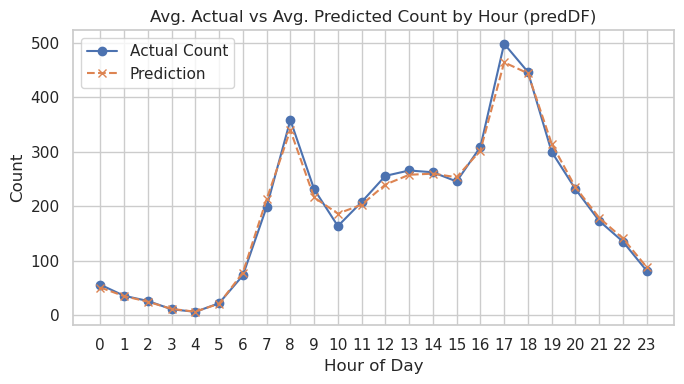

In [245]:
import pyspark.sql.functions as F

# Aggregate by hour (average or sum)
hr_df = predDF.groupBy("hr").agg(
    F.avg("count").alias("avg_count"),
    F.avg("prediction").alias("avg_prediction")
).orderBy("hr")

# Convert to Pandas
hr_pd = hr_df.toPandas()

# Plot line chart
plt.figure(figsize=(7, 4))

plt.plot(hr_pd['hr'], hr_pd['avg_count'], label='Actual Count', linestyle='-', marker='o')
plt.plot(hr_pd['hr'], hr_pd['avg_prediction'], label='Prediction', linestyle='--', marker='x')

plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Avg. Actual vs Avg. Predicted Count by Hour (predDF)')
plt.xticks(hr_pd['hr'])  # Ensure all 24 hours are shown
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

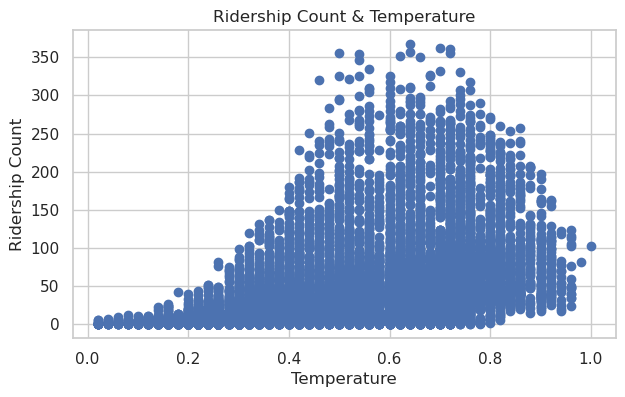

In [246]:
fig, ax = plt.subplots(figsize = (7, 4))
plt.xlabel('Temperature')
plt.ylabel('Ridership Count')
plt.title('Ridership Count & Temperature')

ax.scatter(x = pandas_df['temp'], y = pandas_df['casual'])
# plt.legend()
plt.show()
# print(pandas_df.columns.tolist())